# Table of Contents
- [Initialization](#initialization)
- [Utilities](#utilities)
- [Overview](#overview)
- [Projective Transform and Warping](#projective-transform-and-warping)
- [Scale Invariant Feature Transform (SIFT)](#scale-invariant-feature-transform-sift)
  - [SIFT in Theory](#sift-in-theory)
  - [SIFT in Practice](#sift-in-practice)
- [Matching Descriptors](#matching-descriptors)
- [Random Sample Concensus (RANSAC)](#random-sample-concensus-ransac)
  - [Ransac for Line Fitting](#ransac-for-line-fitting)
  - [Find a Perspective Transform using Ransac](#find-a-perspective-transform-using-ransac)
- [Stitching it all together](#stitching-it-all-together)
- [A Better Stitch (Bonus Points)](#a-better-stitch-bonus-points)
- [Stitching your own Images (Bonus Points)](#stitching-your-own-images-bonus-points)


# CV LabExercise: Image Stitching using SIFT

## Initialization

In [611]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import warp
import cv2
from matplotlib.patches import ConnectionPatch

This week, we are working with SIFT. For this we need the right version of the `opencv` package. 
You can install the package by running the following command:

```bash
conda activate YOUR_ENV_NAME
pip install opencv-contrib-python
```

This is important, since the SIFT algorithm is patented and not included in the default `opencv` package.

Hidden in this cell are some $\LaTeX$ macros
$
\def \v#1{\mathbf{#1}}
\def \hv#1{\widetilde{\mathbf{#1}}}
\def \setR{\mathbb{R}}
\def \T{^\top}
\def \inv{^{-1}}
\def \pfrac#1#2{\frac{\partial #1}{\partial #2}}
$

## Utilities

In this section there is some code that is needed later on in this exercise. Make sure this code is executed before using it.

In [612]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)
        
def draw_keypoints(kps, nkps=None, ax=None, marker='x', 
                   marker_size=10, scale_and_orientation=True):
    if ax is None:
        ax = plt.gca()
    if nkps is None:
        nkps = len(kps)
    xs = [kp.pt[0] for kp in kps]
    ys = [kp.pt[1] for kp in kps]
    ax.scatter(xs, ys, marker=marker)
    if scale_and_orientation:
        for kp in kps[:nkps]:
            x, y = kp.pt
            r = kp.size / 2
            angle = kp.angle/2/np.pi
            ax.add_artist(plt.Circle((kp.pt), kp.size/2, 
                                     color='green', fill=False))
            ax.add_artist(plt.Arrow(x, y, r*np.cos(angle), 
                                    r*np.sin(angle), color='red'))
            


def draw_matches(f1, kps1, f2, kps2, matches, 
                 horizontal=True, figsize=(15,15)):
    if horizontal:
        fig, axs = plt.subplots(1,2, figsize=figsize)
    else:
        fig, axs = plt.subplots(2,1, figsize=figsize)
    
    axs[0].imshow(f1)
    axs[1].imshow(f2)
    
    # get the indexes of the matches
    idx1 = [m.queryIdx for m in matches]
    idx2 = [m.trainIdx for m in matches]
    
    xs1 = [kps1[i].pt[0] for i in idx1]
    ys1 = [kps1[i].pt[1] for i in idx1]
    xs2 = [kps2[i].pt[0] for i in idx2]
    ys2 = [kps2[i].pt[1] for i in idx2]
    
    
    for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        con = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA="data", coordsB="data",
                      axesA=axs[0], axesB=axs[1], color='g')
        axs[1].add_artist(con)            


## Overview

The objective of this \"project\" is to develop software that stitches two or more images of the same scene together. This report focuses on stitching just two images and outlines the primary steps of the algorithm:

1. **Locate keypoints** in both images. Each keypoint includes its position $(x, y)$, scale $s$, orientation $\theta$, and a descriptor $\mathbf{d}$ that captures the local image features.

2. **Match keypoints** between the two images. A match is found when the difference $\|\mathbf{d} - \mathbf{d}'\|$ between descriptors is sufficiently small, indicating that the local areas around $(x, y)$ in image 1 and $(x', y')$ in image 2 look nearly identical.

3. **Estimate the transformation** $P$ that aligns points from image 1 to their counterparts in image 2. This step uses the RANSAC algorithm to robustly identify correct matches among the keypoints.

4. **Warp the images** to a unified coordinate system and merge them to produce the final stitched image.

For this project, you can utilize the SIFT feature detector available in OpenCV, but you will need to implement the RANSAC algorithm yourself to gain a practical understanding of the process.


This exercise begins with the task of stitching two small views of Rembrandt's "The Night Watch" into a unified coordinate frame. The images are saved as JPEG files. Upon loading, these images are represented as arrays with the shape \((M, N, 3)\) and a data type of `uint8`.


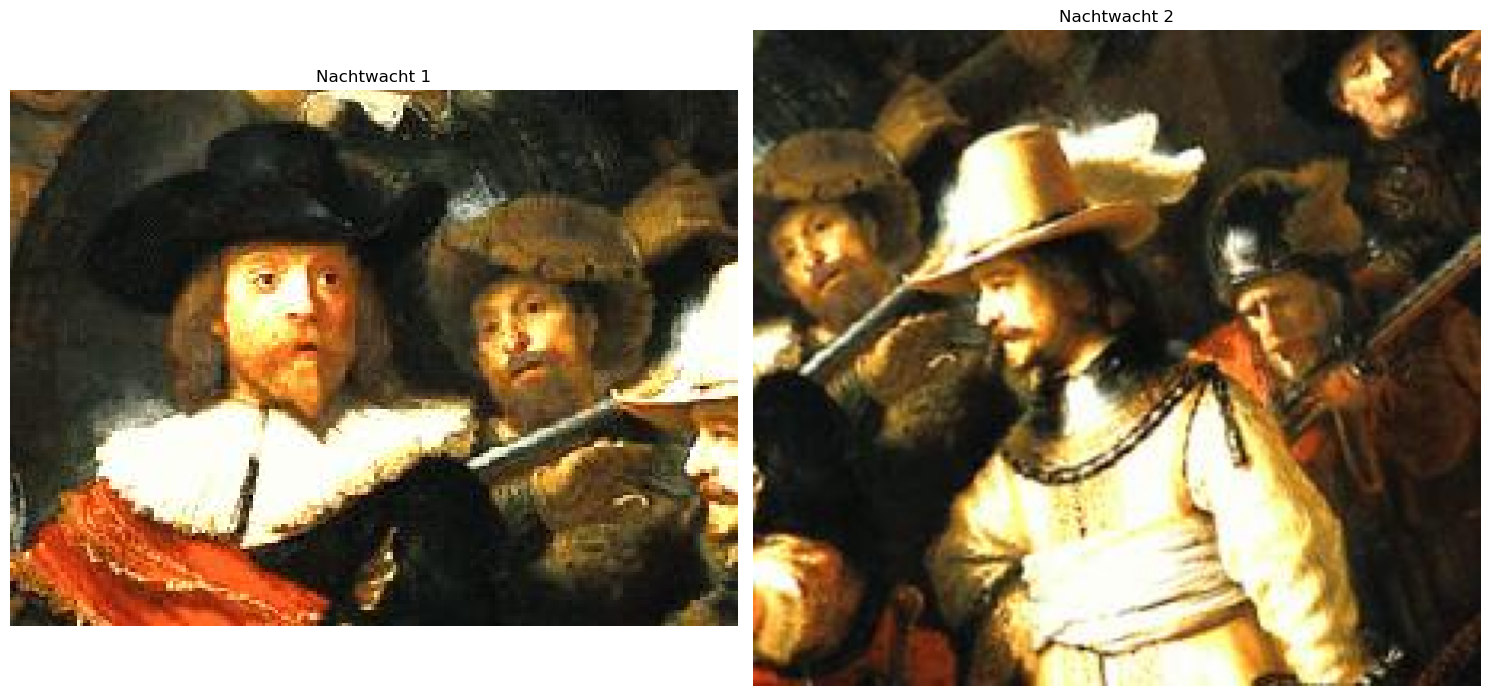

In [613]:
f1 = plt.imread('nachtwacht1.jpg')
f2 = plt.imread('nachtwacht2.jpg')
plt.figure(figsize=(15,15))
imshow_row([(f1, "Nachtwacht 1"),
            (f2, "Nachtwacht 2")])
plt.tight_layout()

Note that the scale of both images is different and also the orientation is slightly different. In fact, it will turn out that we really need a projective transform to relate the coordinate frames of these two images.

In this exercise, we will proceed with the following steps:

1. **Test the `projective_transform_matrix` implementation** using 4 and 6 point correspondences in the images.
   
2. **Automate point correspondence and transformation estimation**:
   - Instead of manually selecting point correspondences, we will use the SIFT algorithm and RANSAC method.
     - **SIFT**: We will utilize the OpenCV implementation.
     - **RANSAC**: You are required to implement your own version of this algorithm.
   
3. **Image warping**:
   - Create an image filled with zeros.
   - Warp both "The Night Watch" images into the coordinate frame of the new image.
   - Ensure that the new image completely contains the two merged "The Night Watch" images. (Note: This comprehensive inclusion is a requirement not met in the initial part of this exercise.)


## Projective Transform and Warping

In the nachtwacht1 and nachtwacht2 image we have manually picked 4 corresponding points, these are collected in the arrays ``xy`` and ``xaya``.

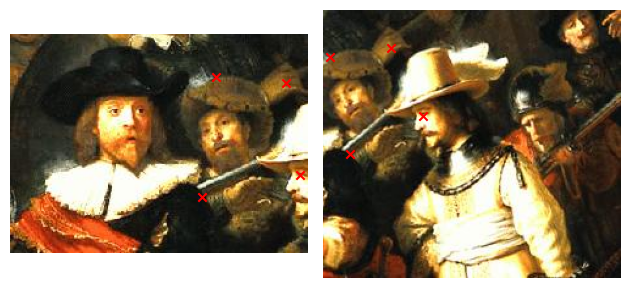

In [614]:
xy = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124]])
xaya = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy[:,0], xy[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya[:,0], xaya[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

Using the identified point correspondences, you can compute the projective transform $ P $ that maps coordinates from the first image to corresponding coordinates in the second image. We will utilize the following functions from previous labs:
- `projective_transform_matrix`
- `e2h`
- `h2e`

In [615]:
def projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4):
    M = np.empty((0,9))
    for (x, y), (xa, ya) in zip([x1, x2, x3, x4], [xa1, xa2, xa3, xa4]):
        M = np.append(M, 
                      np.array([[x, y, 1, 0, 0, 0, -xa*x, -xa*y, -xa],
                                [0, 0, 0, x, y, 1, -ya*x, -ya*y, -ya]]),
                      axis=0)
    _, _, VT = np.linalg.svd(M)
    p = VT[-1]
    P = p.reshape((3,3))
    return P

def e2h(x):
    if len(x.shape) == 1:
        return np.hstack((x, [1]))
    return np.vstack((x, np.ones(x.shape[1])))
    
def h2e(tx):
    return tx[:-1]/tx[-1]


In [616]:
P = projective_transform_matrix(xy[0], xy[1], xy[2], xy[3],
                           xaya[0], xaya[1], xaya[2], xaya[3])

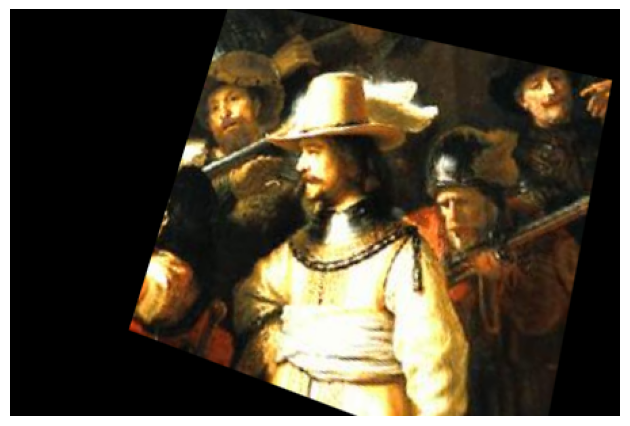

In [617]:
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

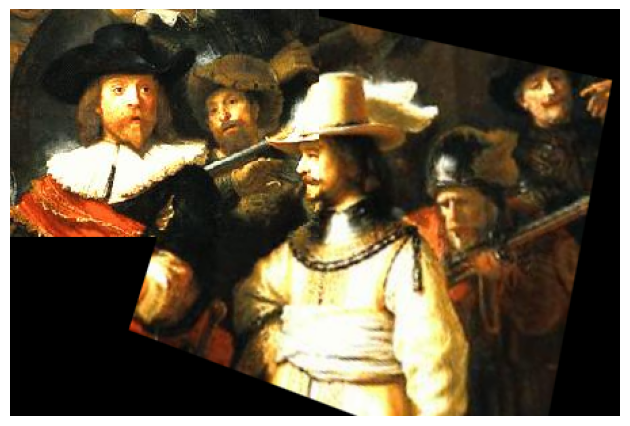

In [618]:
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

Be sure to understand what is going on in the code above. Can you explain why you didn't need the inverse of $P$ in the warp function?

The image stitching may not appear perfect as the border of the first image is still visible. This imperfection arises because our manually selected points were not exact matches between the two images. To enhance the precision of the stitch, using more than four points can provide a better fit for these handpicked correspondences.

**Update for `projective_transform_matrix`**

You are required to modify the `projective_transform_matrix` function to handle more than the minimal four point correspondences for estimating the projection matrix. Below, we provide six point correspondences to assist with this enhancement:

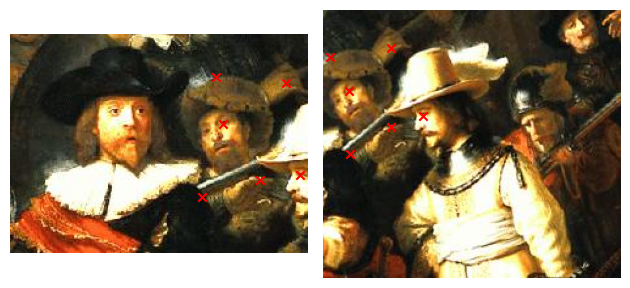

In [619]:
xy6 = np.array([[ 157, 32],
               [ 211, 37],
               [ 222,107],
               [ 147,124],
               [ 163, 68],
               [ 191,111]])
xaya6 = np.array([[  6, 38],
                 [ 56, 31],
                 [ 82, 87],
                 [ 22,118],
                 [ 21, 66],
                 [ 56, 96]])
plt.subplot(1,2,1)
plt.imshow(f1)
plt.scatter(xy6[:,0], xy6[:,1], marker='x', color='r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(f2)
plt.scatter(xaya6[:,0], xaya6[:,1], marker='x', color='r')
plt.axis('off')
plt.tight_layout()

**Enhancing the `projective_transform_matrix` function**

The original function `projective_transform_matrix`, which takes four point correspondences, computes a unique projective mapping for those points. Your task now is to generalize this function to handle more than four point correspondences. This enhancement should produce a projective transformation that best approximates all given target points.



**Introducing `projective_fit_model`**

We will rename this generalized function to `projective_fit_model`. It should accept a single parameter `data`, which is an iterable of point pairs. This design will align with further applications and manipulations later in this notebook.


In [620]:
def projective_fit_model(data):
    """
    data is an iterable of pairs (input, output). Each pair consists of two Euclidean 2d vectors.
    
    Calculate the projection matrix P that maps all input points onto their corresponding output point,
    or as close as possible.
    
    data will have at least four pairs. If it has exactly four pairs it should behave the same as
    `projective_transform_matrix` (possibly up to a multiplicative constant):
    
        projective_transform_matrix(x1, x2, x3, x4, xa1, xa2, xa3, xa4) ==
            projective_fit_model([(x1, xa1), (x2, xa2), (x3, xa3), (x4, xa4)])
    """
    # YOUR CODE HERE (Replace this and the following line with your code)
    M = np.empty((0,9))
    for (x, y), (xa,ya) in data:
        M = np.append(M, 
                      np.array([[x, y, 1, 0, 0, 0, -xa*x, -xa*y, -xa],
                                [0, 0, 0, x, y, 1, -ya*x, -ya*y, -ya]]),
                      axis=0)
    _, _, VT = np.linalg.svd(M)
    p = VT[-1]
    P = p.reshape((3,3))
    return P

In [621]:
P6 = projective_fit_model(zip(xy6, xaya6))

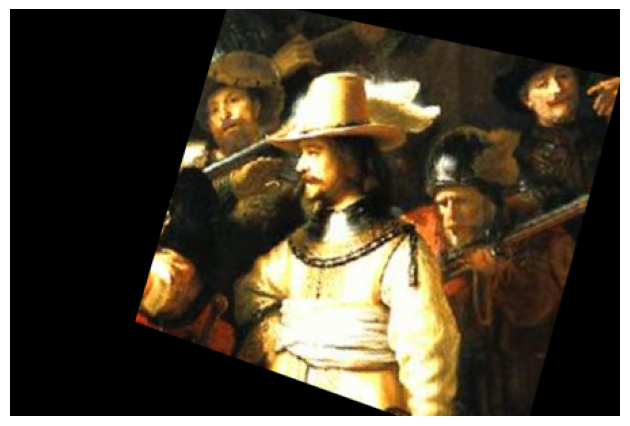

In [622]:
f_stitched6 = warp(f2, P6, output_shape=(300,450))
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

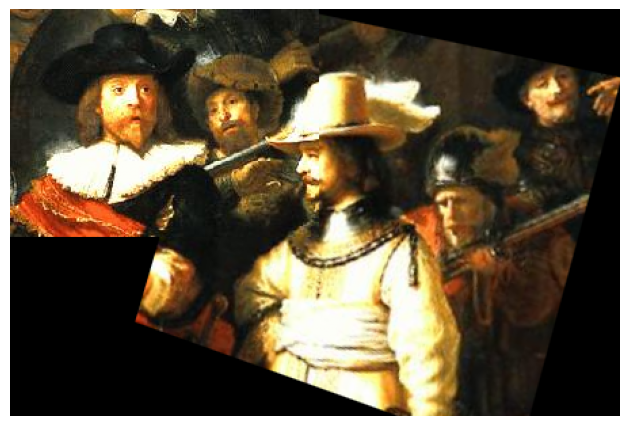

In [623]:
M, N = f1.shape[:2]
f_stitched6[:M, :N, :] = f1/255.0 #rescaling f1 to play nice with the warp function
plt.imshow(f_stitched6);
plt.axis('off');
plt.tight_layout()

Even with six manually selected point correspondences, the results may not be optimal, as evidenced by the misalignment visible around the white hat at the border of both images. In subsequent parts of this lab exercise, we will use SIFT and RANSAC techniques. These methods automatically identify corresponding points between images with greater accuracy, significantly improving the stitching results.


## Scale Invariant Feature Transform (SIFT)

We will utilize the SIFT algorithm provided by OpenCV, which incorporates several sophisticated techniques from the field of computer vision. If you are interested in seeing how complex and optimized computer vision code can look, you can examine the [source code here](https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/sift.cpp). This example showcases how intricate code can become when optimizing for peak performance.


OpenCV encodes a color pixel with a BGR triple of values whereas Matplotlib and skimage use RGB triplets. That is why in the code below you see the cryptic ``f1[:,:,::-1]`` indexing.

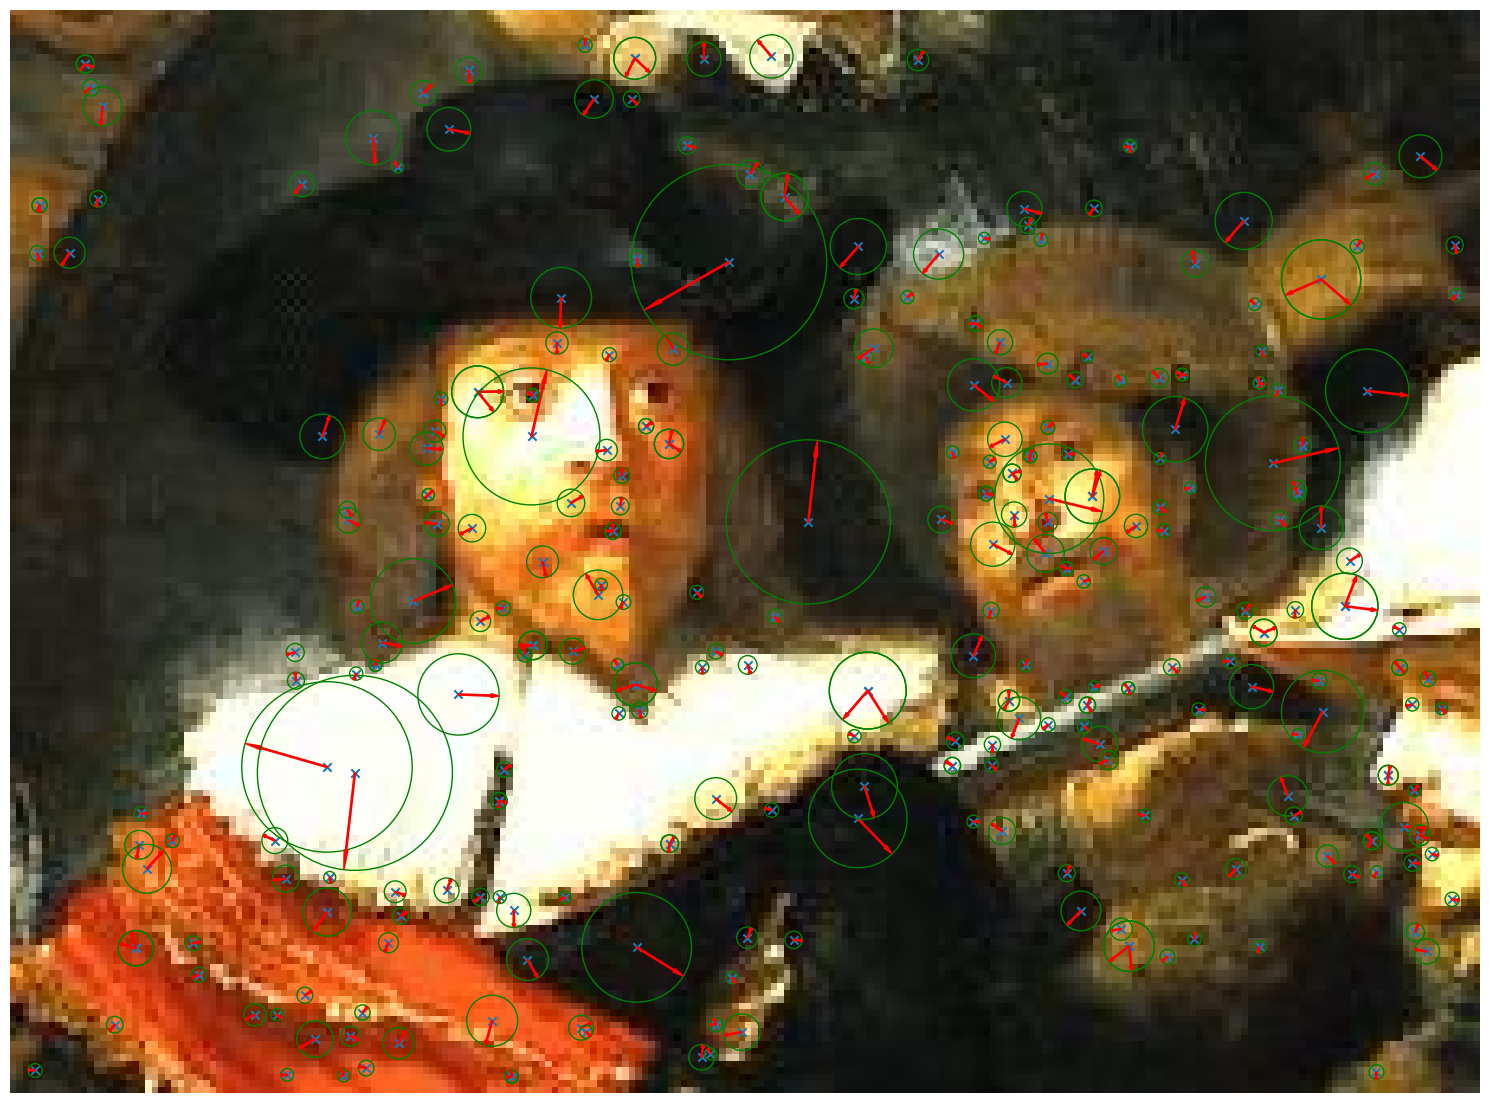

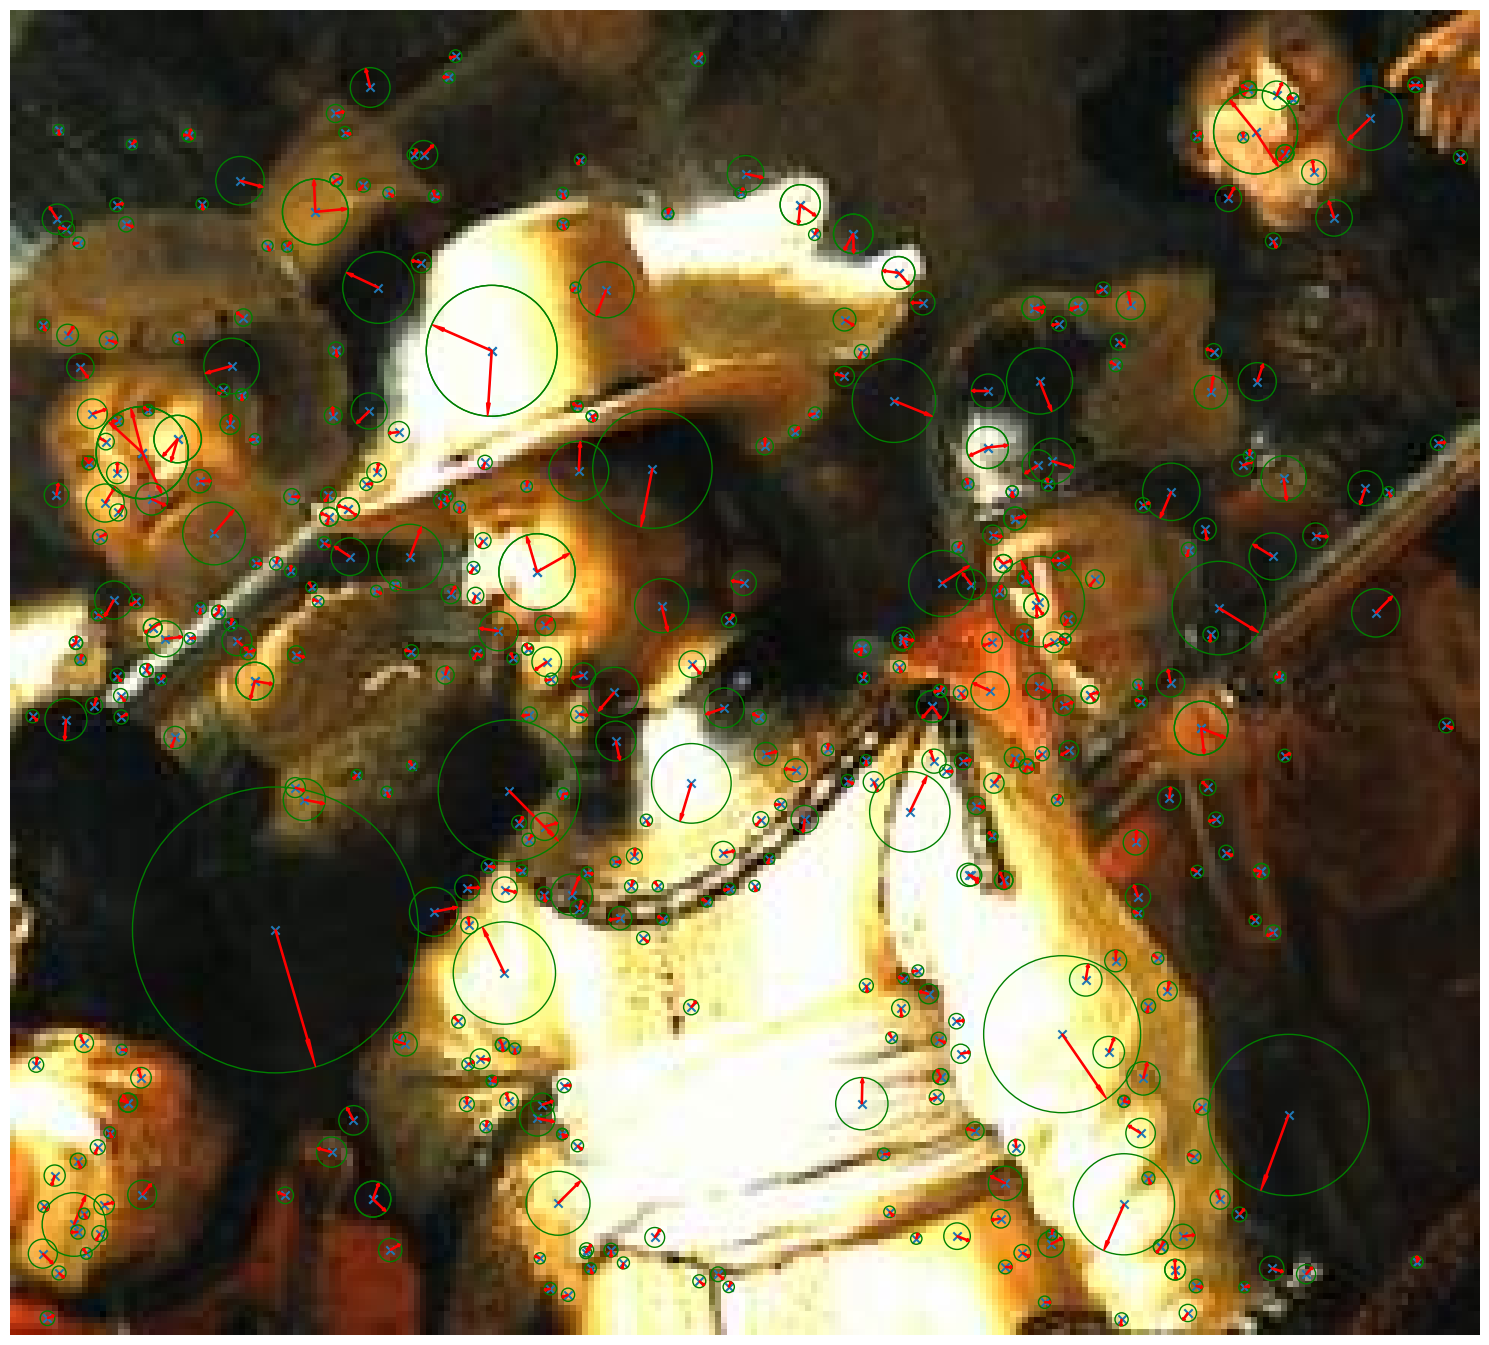

In [624]:
fd = cv2.SIFT_create()
kp1, d1 = fd.detectAndCompute(f1[:,:,::-1], None)
kp2, d2 = fd.detectAndCompute(f2[:,:,::-1], None)
plt.figure(figsize=(15,15))
plt.imshow(f1)
draw_keypoints(kp1)
plt.axis('off')
plt.tight_layout()
plt.figure(figsize=(15,15))
plt.imshow(f2)
draw_keypoints(kp2)
plt.axis('off')
plt.tight_layout()

## Matching Descriptors

After computing the SIFT descriptors, you can use them to identify potential matches between keypoints in two images. A keypoint from image 1 represented as $(x,y,s,\theta, \mathbf{d})$ and a keypoint from image 2 as $(x',y',s',\theta', \mathbf{d'})$ are considered a match if the distance $\|\mathbf{d}-\mathbf{d'}\|$ is sufficiently small.

To find matches, we will employ the 'brute force matcher' provided by OpenCV. This greedy algorithm selects the pair of keypoints, one from each image, with the smallest descriptor distance as the first match. These keypoints are then removed from consideration, and the process repeats until there are no more descriptors left to match in one of the images.

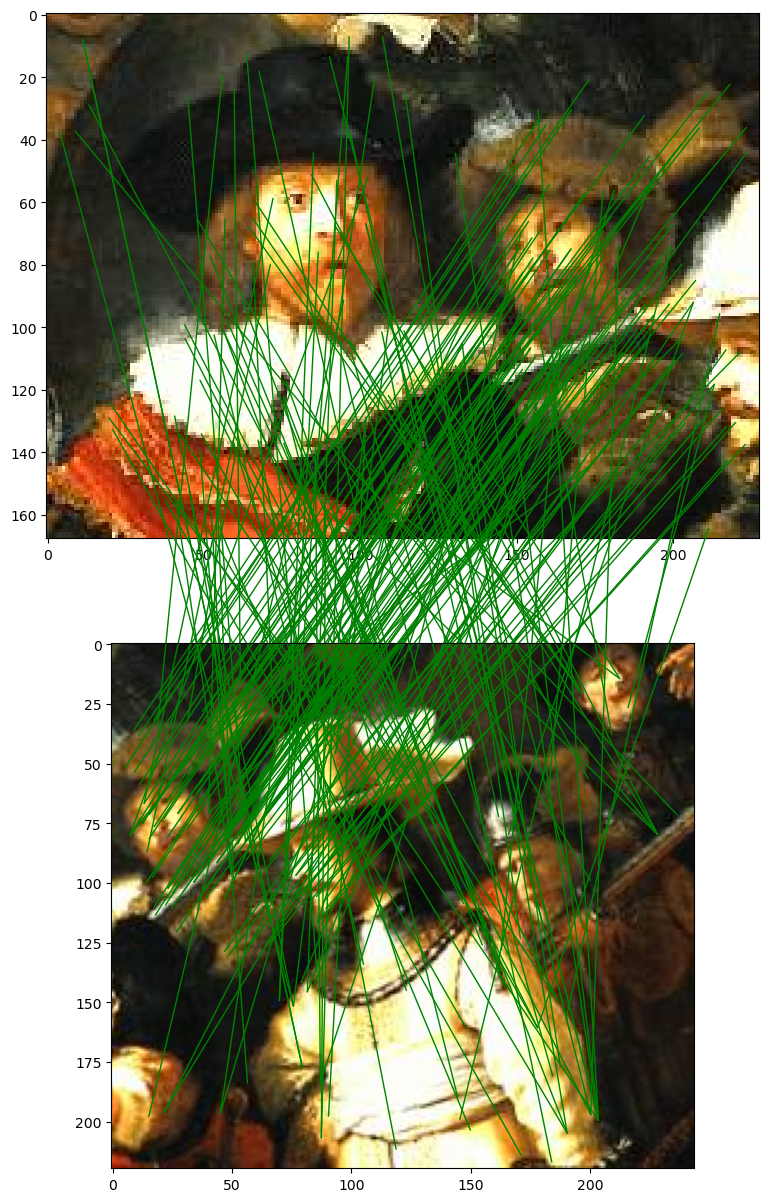

In [625]:
matcher = cv2.BFMatcher()
matches = matcher.match(d1,d2)
matches = sorted(matches, key = lambda x: x.distance)

draw_matches(f1, kp1, f2, kp2, matches[:200], figsize=(15,15), horizontal=False)

Observe that you see a lot of 'wrong' matches in the above images. But are they really wrong? What is happening? Why do we find these 'wrong' matches? And what do we mean with 'wrong' really? 

These 'wrong' matches will be filtered out in the next section. The filtering will *not* be done based on visual appearance but on the possibility to find a common mapping of points in image 1 to the corresponding points in image 2.

In case you are interested in algorithms and datastructures it might be interesting to realize that such a brute force approach to matching (essentially the problem of finding closest points in high dimensional space, in our case $\v d\in\setR^{128}$) is rather slow. It turns out that a faster search for the closest point is not trivial. In OpenCV an *approximate* but faster algorithm is available.

## Random Sample Concensus (RANSAC)

RANSAC (Random Sample Consensus) is a robust statistical method used to estimate the parameters of a mathematical model from a set of observed data which contains outliers.

### Steps of the RANSAC Algorithm:

1. **Fit Model**: This function takes a randomly selected subset of `n_model_data` (input, output) pairs (the minimum number necessary to define the model) and estimates the model parameters to map inputs to outputs as closely as possible.

2. **Test Model**: This function evaluates how well a given model fits all available (input, output) pairs. It identifies the pairs that fit the model within a specified threshold as *inliers*.

3. **Iterate**: Repeat the above two steps for `n_iter` iterations, each time with a different random subset of `n_model_data`. The model that yields the highest number of inliers is considered the optimal model.

4. **Refine Model**: Re-estimate the model parameters using all inliers identified by the optimal model.

### Task:

- Research the RANSAC algorithm further (e.g., on Wikipedia).
- Implement the `ransac` function as described. For examples of `fit_model` and `test_model`, refer to the subsequent section on line fitting with RANSAC.

### Performance Requirements:

Your implementation of RANSAC should be efficient; the provided test cell should complete within a few seconds. One of the tests will assess both the speed and accuracy of your function.

### Model Agnosticism:

Note that RANSAC is designed to be agnostic regarding the type of model it fits, provided there is consistency between the model and the data used by the `fit_model` and `test_model` functions. This versatility allows the same RANSAC framework to be used for different problems, such as line fitting and image alignment.


In [626]:
def ransac(data, fit_model, test_model, test_model_pars, n_model_data, n_iter):
   """
   Use of RANSAC to fit a model to data
   
   Parameters
   ==========
   
   data: list
      each item in data is a tuple (input, output)
   fit_model: callable
      a function that takes data (a list of tuples of 
      (input, output) pairs) and returns an object describing 
      the fitted model
   test_model: callable
      a function that takes as first parameter the model 
      (return value of fit_model) and as second argument a list
      of (input, output) tuples (it expects all data tuples 
      including those used for the estimation). 
      It returns an array with the indices in the list of tuples 
      (second parameter) of all data tuples that fit the model 
      (i.e. the inliers)
   test_model_pars: dict
      a dictionary that is passed to the ``test_model`` function used to set
      a threshold to determine if an (input, output) pair is an inlier or not.
   n_model_data: int
      the number of data tuples to be used to fit the model
   n_iter: int
      number of iterations 
   
   Return Value
   ============
   (model, inliers): tuple
      model: the model, as returned by fit_model
      inliers: the indices of the inliers of the returned model 
         (not just the data points used to fit the model)
   """
   # YOUR CODE HERE (Replace this and the following line with your code)
   best_inliers = []
   best_model = None
   for i in range(n_iter):
      sample = np.random.choice(len(data), n_model_data)
      sample_data = [data[i] for i in sample]
       
      # fit model
      model = fit_model(sample_data)
       
      # test model
      inliers = test_model(model, data, **test_model_pars)
       
      if len(inliers) > len(best_inliers):
           best_inliers = inliers
   
   inlier_data = [data[i] for i in best_inliers]
   best_model = fit_model(inlier_data)

   return (best_model, best_inliers)


### Ransac for Line Fitting

Although fitting a line isn't necessary for image stitching, it serves as an excellent introduction to the RANSAC algorithm due to its simpler nature and ease of visualization.

### Generating Noisy Data for Line Fitting:

1. **Data Creation**: We start by generating random $ x $ values within the range from 0 to 10.
2. **Assigning $ y $ Values**:
   - For the majority of these $ x $ values, we assign $ y $ values that lie on a predefined straight line but include a random error to simulate real-world data noise.
   - For the remaining $ x $ values, we assign completely random $ y $-values to introduce outliers in the dataset.

This setup creates a basic scenario for testing how effectively the RANSAC algorithm can identify and ignore outliers while estimating the most probable line that fits the majority of the data points.

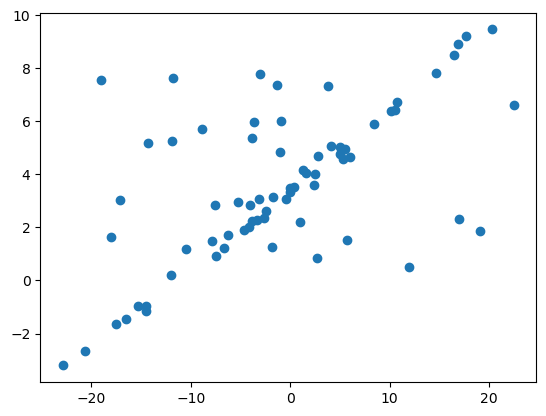

In [627]:
np.random.seed(7)
x = 10 * np.random.randn(70);
y = 0.3 * x + 3.4
y = y + 0.3 * np.random.randn(len(y))
y[40:] = 8 * np.random.rand(30)
plt.plot(x,y,'o');
data = list(zip(x,y)) # a list of pairs (input,output), 
                      # in this case (x,y) pairs

Given a number of $n>2$ pairs of points $(x,y)$ we can fit a line using a LSQ procedure:

In [628]:
def fit_line(data):
    """Fit a line to (x,y) pairs using a LSQ procedure"""
    X = np.array( [ [a, 1] for (a,b) in data])
    y = np.array( [ b for (a,b) in data])
    return np.linalg.lstsq(X, y, rcond=None)[0]

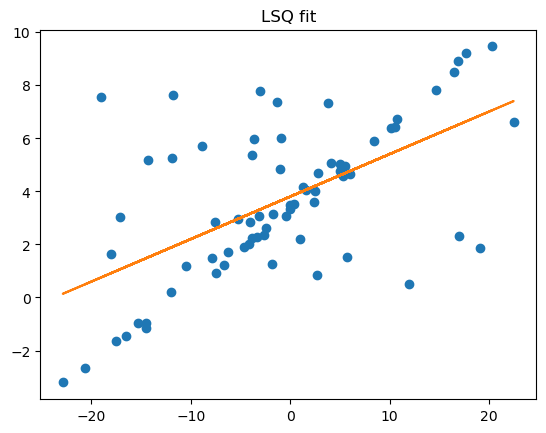

In [629]:
line_lsq = fit_line(data)
yfit_lsq = line_lsq[0]*x + line_lsq[1]
plt.plot(x,y,'o')
plt.plot(x,yfit_lsq)
plt.title('LSQ fit');

Evidently this is not the line we are looking for. We need to get rid of the outliers, i.e., the points $(x,y)$  that are not from the straight line. With the ``test_line`` function we can find the inliers for a given model.

In [630]:
def test_line(line, data, max_error=1):
    x = np.array( [ x for x, _ in data])
    y = np.array( [ y for _, y in data])
    yp = line[0]*x + line[1]
    err = np.abs(y-yp)
    inliers_idx = np.flatnonzero(err<max_error)
    return inliers_idx

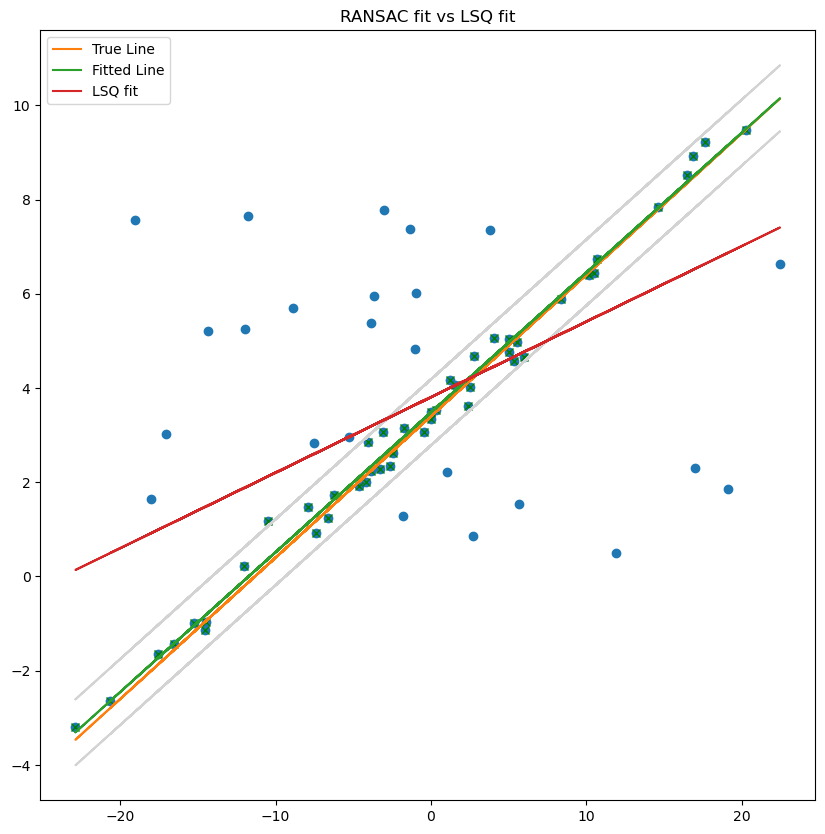

In [631]:
# Visual test (for the first test case below)

plt.figure(figsize=(10,10))
me = 0.7
line = None
inliers_idx = None
line, inliers_idx = ransac(data, fit_line, test_line, 
                           {'max_error':me}, 4, 1000)
plt.plot(x, y, 'o');
plt.plot(x[inliers_idx], y[inliers_idx], 'gx');
yfit = line[0]*x + line[1]
plt.plot(x, 0.3 * x + 3.4, label='True Line')
plt.plot(x,yfit, label='Fitted Line')
plt.plot(x,yfit+me, 'lightgray')
plt.plot(x,yfit-me, 'lightgray')
plt.plot(x,yfit_lsq, label='LSQ fit')
plt.legend()
plt.title('RANSAC fit vs LSQ fit');

### Find a Perspective Transform using Ransac

At this stage in the stitching process, we have already identified and extracted keypoints from both images, stored in arrays `kp1` for the first image and `kp2` for the second image. These keypoints have been matched, and the pairs are stored in the `matches` data structure.

### Preparing Data for Transformation Estimation:

- **Creating Data List**: We will now create a list named `data`. Each element in this list will be a tuple of tuples `((x1, y1), (x2, y2))`. This format encodes the coordinates of matching keypoints from the first and second images respectively.

This step is crucial for preparing the matched keypoints data, which will be used in the subsequent steps to estimate the geometric transformation needed to align and stitch the images effectively.

In [632]:
data = [((kp1[m.queryIdx].pt), (kp2[m.trainIdx].pt)) for m in matches]

Next, we need a ``fit_model`` and ``test_model`` function in order to use Ransac. You have already defined ``projective_fit_model`` which takes a set of point correspondences and finds the best projective matrix ``P`` that maps points (x1, y1) to (x2, y2). Now define `projective_test_model`.

In [633]:
def projective_test_model(P, data, max_error=2):
   """
   Finds indices of inliers in the data for projective transformation
   given by P, where the inliers are determined by the max_error.
   
   Parameters
   ==========
   
   P: numpy array
      a 3x3 matrix giving a projective transformation of the plane
   data: list
      each item in data is a tuple (input, output), each consisting
      of a point (numpy array with shape (2,)) in the plane.
   max_error: float 
      the maximum Euclidean distance between P(input) and output 
      for the pair (input, output) to count as an inlier
   
   Return Value
   ============
   inliers: numpy array
      the indices of the inliers in data, in order
   """
   # YOUR CODE HERE (Replace this and the following line with your code)
   inliers = []
   for i, (x, xa) in enumerate(data):
      if type(x) == tuple:
         x = np.array(x)
         xa = np.array(xa)
      xh = e2h(x)
      xh_p = P @ xh
      xa_p = h2e(xh_p)
      err = np.linalg.norm(xa - xa_p)
      if err < max_error:
         inliers.append(i)
   return np.array(inliers)

In [634]:
# You can use the assert statements in this cell to locally test your projective_test_model.
# There will be other tests in the codegrade autograding.

x = np.array([[-0.30099881,  0.34786734],
       [-0.43573294,  0.64231348],
       [-1.28532622,  1.13860487],
       [ 0.54744592,  0.51493255],
       [-0.20087976,  0.18980669],
       [-1.27066563, -0.20241131],
       [-0.64972417, -2.02646797],
       [-2.38189517, -0.1663487 ]])
xa = np.array([[ 0.369618  ,  0.67714101],
       [ 1.72259747, -0.04050429],
       [ 2.22190863, -1.06356781],
       [ 0.80900945, -2.48119838],
       [-0.53911635,  1.2555933 ],
       [ 0.07221467, -0.24165753],
       [-2.37579957,  0.87320773],
       [ 0.47265383, -0.59226317]])
P = np.array([[ 1.        , -1.8574528 ,  0.77686397],
                [-1.0861612 ,  0.63049228, -0.85821791],
                [ 1.01049866,  0.34736811, -0.27737639]])
assert np.array_equal(projective_test_model(P, list(zip(x, xa))), np.arange(8))
xa[::2, 0] += 1
xa[::4, 0] += 1
xa[::3, 1] += 1
xa[1::3, 1] += 1
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 0.5), np.array([5]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 1.1), np.array([1, 2, 3, 5, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 2), np.array([1, 2, 3, 5, 6, 7]))
assert np.array_equal(projective_test_model(P, list(zip(x, xa)), 3), np.arange(8))

[[ 1.22414318e+02 -3.21500236e+01  2.30429354e+04]
 [ 2.64815611e+01  1.59234441e+02 -1.28349877e+03]
 [-1.95208295e-01  5.18614087e-02  1.45518498e+02]]


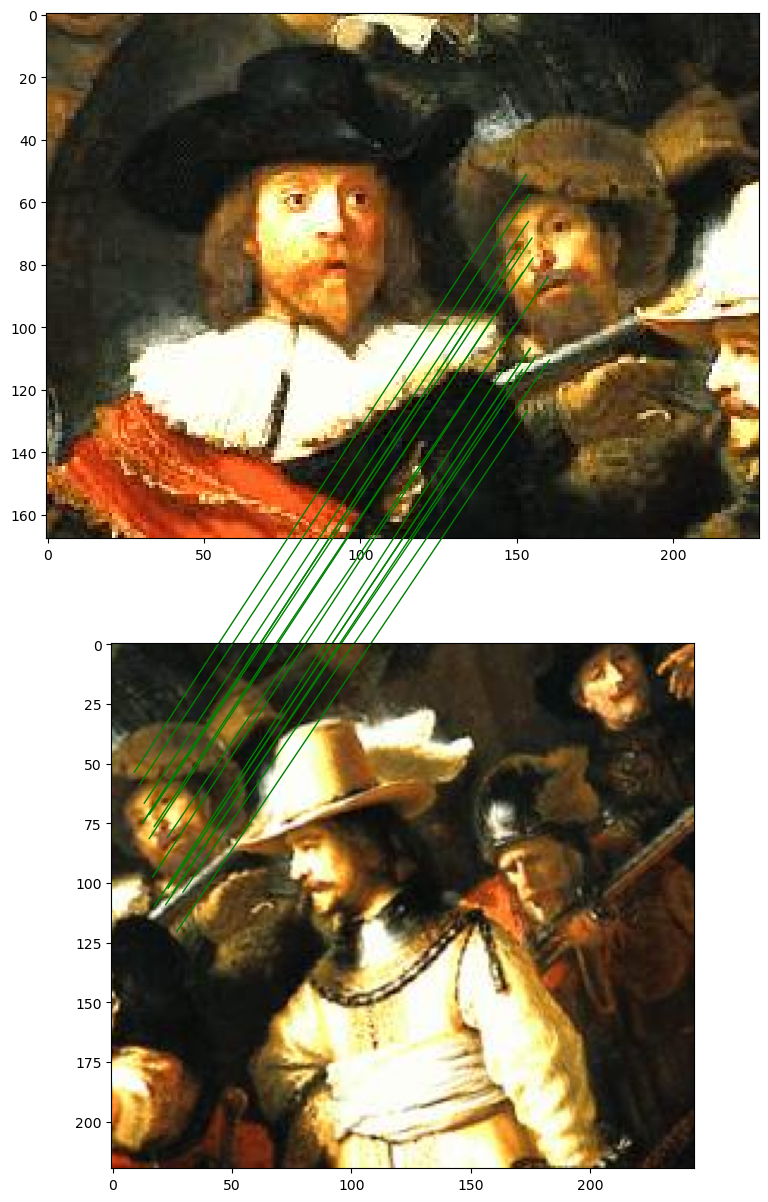

In [635]:
P, inliers = ransac(data, projective_fit_model, 
                    projective_test_model, {'max_error':1}, 4, 1000) 
print(np.linalg.inv(P))
draw_matches(f1, kp1, f2, kp2, np.array(matches)[inliers], 
             horizontal=False)

## Stitching it all together

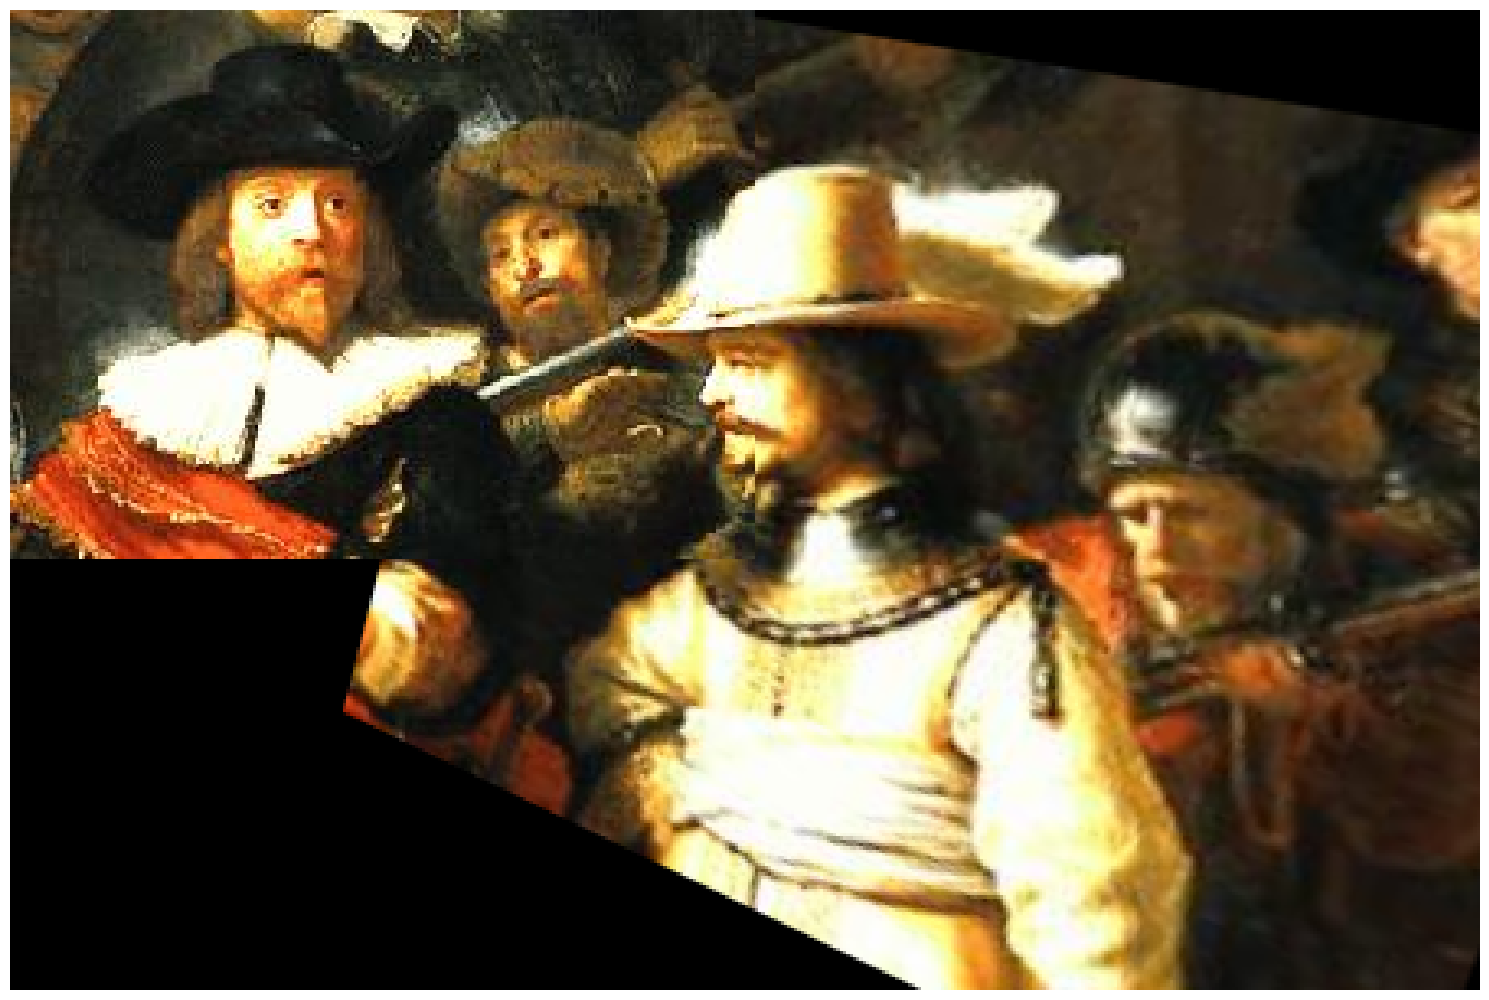

In [636]:
plt.figure(figsize=(15,15))
f_stitched = warp(f2, P, output_shape=(300,450), preserve_range=True).astype(np.uint8)
M, N = f1.shape[:2]
f_stitched[:M, :N, :] = f1
plt.imshow(f_stitched);
plt.axis('off');
plt.tight_layout()

## A Better Stitch (Bonus Points)

The process of stitching the images involved several key steps:

1. **Warping Image**: The second image (`f2`) was warped onto the coordinate frame of the first image (`f1`). A larger canvas than that of `f1` was used to accommodate the second image.

2. **Copying Image**: The first image was then copied onto this larger image, positioned as the top-left content.

This approach was primarily based on trial and error. Although it enabled the combination of the two images, there were visible shortcomings. Notably, some parts of the second image did not appear within the bounds of the resulting stitched image, indicating that the chosen method and parameters might need adjustments for better coverage.

### Next Steps:

To enhance the visibility of both images in the final stitched product, further refinement in the warping and placement parameters is necessary. This may involve more precise alignment techniques or adjustments to the size and scale of the images relative to the canvas.

Your current objective is to define a new image frame that can fully contain both stitched images without clipping any part. Observations from previous attempts show that additional space at the top and bottom of the frame is necessary.

### Steps to Complete This Task:

1. **Calculate the Bounding Box**:
   - Determine the bounding box for the transformed second image. This involves calculating the coordinates of the four corners of the second image after applying the projective transformation with respect to the coordinate frame of the first image.

2. **Apply Coordinate Transforms**:
   - Utilize your knowledge of coordinate and homogeneous transformations. Specifically, you will need to employ a translation matrix to adjust the position of the second image within the larger frame.
   
### Implementation Guidance:
   
- Start by identifying the extremities (min and max points) of the second image after transformation.
- Compute the required dimensions of the new image frame based on these extremities, ensuring that it extends sufficiently in all directions to include both images completely.
- Use translation transformations to properly align the images within this new frame.

This task involves applying theoretical knowledge to practical problems, refining your understanding of transformations in image processing.

## Stitching your own Images (Bonus Points)

Try to stitch multiple overlapping photos of the same scene into a single, large image. Ensure the photos overlap correctly and are suitable for stitching.

### Steps to Complete This Task:

1. **Start with Two Images** (2 points):
   - Select images that either depict flat surfaces (such as posters on walls or building facades) or panoramic views taken from a single point. This approach minimizes perspective issues and enhances the likelihood of successful stitching.

2. **Advance to Three Images** (1 point):
   - Plan to stitch three images in sequence (f1 with f2, and f2 with f3), considering the overlap and compatibility from the start.

3. **Challenge Yourself with Five or Six Images**:
   - Try stitching five or six images for extra challenge and bragging rights. The record in this class is nine images.

### Implementation Guidance:

- **Color Correction**:
  - When stitching real-life images, you might notice color discrepancies due to lighting differences. While important, color correction is beyond the scope of this task and not required for the assignment.

### Using your own images

Note, when doing an assignment with your own images, you have to upload those along with the notebook!